the origin is from the best result of task c of week 5.
cfg.DATASETS.PRECOMPUTED_PROPOSAL_TOPK_TRAIN = 3000 # default is 2000

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pwd
import os
os.chdir("/content/drive/My Drive/Colab Notebooks/M5/week6")
!ls
!pwd

/content
Detectron2_kitti_coco_cityscapes_top_scoring_3000.ipynb  output1
/content/drive/My Drive/Colab Notebooks/M5/week6


In [0]:
output_path = "./output1/"

In [4]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


# Install detectron2

In [7]:
# install dependencies: (use cu100 because colab is on CUDA 10.0)
!pip install -U torch==1.4+cu100 torchvision==0.5+cu100 -f https://download.pytorch.org/whl/torch_stable.html 
!pip install cython pyyaml==5.1
!pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'
import torch, torchvision
torch.__version__
!gcc --version
# opencv is pre-installed on colab

Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 723.9MB 24kB/s 
     |████████████████████████████████| 4.1MB 69.1MB/s 
  Found existing installation: torch 1.4.0
    Uninstalling torch-1.4.0:
      Successfully uninstalled torch-1.4.0
  Found existing installation: torchvision 0.5.0
    Uninstalling torchvision-0.5.0:
      Successfully uninstalled torchvision-0.5.0
     |████████████████████████████████| 276kB 35.7MB/s 
  Created wheel for pyyaml: filename=PyYAML-5.1-cp36-cp36m-linux_x86_64.whl size=44074 sha256=ef5cd7198b8bf9801cbf12880086c810364eeed7a128eca226edce18a74620b5
  Stored in directory: /root/.cache/pip/wheels/ad/56/bc/1522f864feb2a358ea6f1a92b4798d69ac783a28e80567a18b
Successfully built pyyaml
  Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-build-ta4kkc_m
  Running command git

In [8]:
# install detectron2:
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu100/index.html

Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu100/index.html
     |████████████████████████████████| 6.2MB 507kB/s 
  Created wheel for fvcore: filename=fvcore-0.1.dev200410-cp36-none-any.whl size=38762 sha256=35cf1332f792a600fa6eeeef2e7b599bf70c3906ad9a424bcd01a4c1007d946d
  Stored in directory: /root/.cache/pip/wheels/1b/f3/7f/c5b04e55c170323900f35020bd21f8e5aeb6fb436b95a66d23
Successfully built fvcore


# import

In [0]:
# You may need to restart your runtime prior to this, to let your installation take effect
# Some basic setup:
# Setup detectron2 logger

import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import cv2
import random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog

In [6]:
import tensorflow
tensorflow.__version__

'2.2.0-rc2'

# divide the gt

generate the lines of training and validation, and save pkl.
if not, load pkl

In [7]:
import os
def read_gt_txt(gt_txt, gt_path):
    gt_index_str = gt_txt.split(".")[0]
    gt_file = "{}{}".format(gt_path, gt_txt)
    gt = []
    gt_one_frame = []
    time_frame_last = 0
    for line in open(gt_file):
        fields = line.split()
        time_frame = int(fields[0])

        one_instance = [gt_index_str]
        one_instance.extend(fields)

        # print(instance)
        if time_frame == time_frame_last:
            gt_one_frame.append(one_instance)
        else:
            gt.append(gt_one_frame)
            # if time_frame != len(gt):
            #     #raise Exception("time_frame != len(gt)")
            #     print("error")
            gt_one_frame = []
            gt_one_frame.append(one_instance)

        time_frame_last = time_frame

    if len(gt_one_frame) > 0:
        gt.append(gt_one_frame)

    return gt

def read_gt_from_id_seq(seq_list):
    gt_list = []
    for id_seq in seq_list:
        gt_txt = "{}.txt".format(str(id_seq).zfill(4))
        # print(gt_txt)
        gt = read_gt_txt(gt_txt, gt_path)
        gt_list.extend(gt)
    return gt_list

gt_path = "../../KITTI-MOTS/instances_txt/"
train_seq = [0,1,2,3,6,10,12,13,14,16,17,18,19,20]
test_seq = [4,5,7,8,9,11,15]

training = read_gt_from_id_seq(train_seq)
print("length of training is", len(training))
validation = read_gt_from_id_seq(test_seq)
print("length of validation is", len(validation))

length of training is 4654
length of validation is 3273


# Register the dataset

In [0]:
# if your dataset is in COCO format, this cell can be replaced by the following three lines:
# from detectron2.data.datasets import register_coco_instances
# register_coco_instances("my_dataset_train", {}, "json_annotation_train.json", "path/to/image/dir")
# register_coco_instances("my_dataset_val", {}, "json_annotation_val.json", "path/to/image/dir")

import os
import numpy as np
import json
from detectron2.structures import BoxMode
from pycocotools.mask import toBbox, decode
import cv2


def register_from_dataset(dataset_path, dataset):

    dataset_dicts = []
    for idx, v in enumerate(dataset):
        instance_0 = v[0]
        record = {}

        filename = "{}/{}/{}.png".format(dataset_path, instance_0[0], instance_0[1].zfill(6))

        record["file_name"] = filename
        record["image_id"] = idx
        record["height"] = int(instance_0[4])
        record["width"] = int(instance_0[5])

        objs = []
        for instance in v:
            # do like https://github.com/VisualComputingInstitute/mots_tools/blob/master/mots_common/io.py,
            # mask = {'size': [int(fields[3]), int(fields[4])], 'counts': fields[5].encode(encoding='UTF-8')}
            mask_rle = {'size': [int(instance[4]), int(instance[5])], 'counts': instance[6].encode(encoding='UTF-8')}
            box = toBbox(mask_rle)
            
            #convert rle to poly
            mask = decode(mask_rle)
            # https://github.com/facebookresearch/Detectron/issues/100  Sundrops
            # opencv 3.2
            # mask_new, contours, hierarchy = cv2.findContours((mask).astype(np.uint8), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
            # before opencv 3.2
            contours, hierarchy = cv2.findContours((mask).astype(np.uint8), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
            segmentation = []

            for contour in contours:
                contour = contour.flatten().tolist()
                # segmentation.append(contour)
                if len(contour) > 4:
                    segmentation.append(contour)
            if len(segmentation) == 0:
                continue
            #End: convert rle to poly
            # print (segmentation)

            ori_class = int(instance[3])
            if ori_class == 1:
                transform_class = 0
            elif ori_class == 2:
                transform_class = 1
            else:
                # transform_class = 2
                continue

            obj = {
                "bbox": [box[0], box[1], box[0] + box[2], box[1] + box[3]],
                "bbox_mode": BoxMode.XYXY_ABS,
                "segmentation": segmentation,
                "category_id": transform_class,
                "iscrowd": 0
            }
            objs.append(obj)
        record["annotations"] = objs
        dataset_dicts.append(record)
    return dataset_dicts


from detectron2.data import DatasetCatalog, MetadataCatalog

dataset_path = "../../KITTI-MOTS/training/image_02"
# thing_classes = ['Car', 'Pedestrian', 'DontCare']
thing_classes = ['Car', 'Pedestrian']

# g = lambda: register_from_dataset(dataset_path, training)
# g()





In [0]:
DatasetCatalog.register("KITTI_MOTS_training", lambda: register_from_dataset(dataset_path, training))
MetadataCatalog.get("KITTI_MOTS_training").set(thing_classes=thing_classes)
DatasetCatalog.register("KITTI_MOTS_val", lambda: register_from_dataset(dataset_path, validation))
MetadataCatalog.get("KITTI_MOTS_val").set(thing_classes=thing_classes)

KITTI_MOTS_metadata = MetadataCatalog.get("KITTI_MOTS_training")

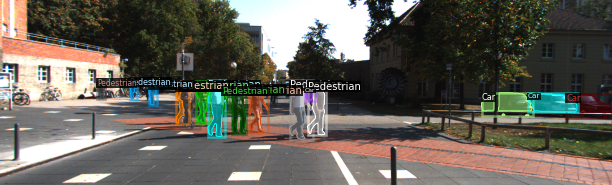

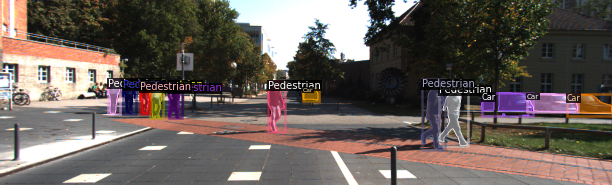

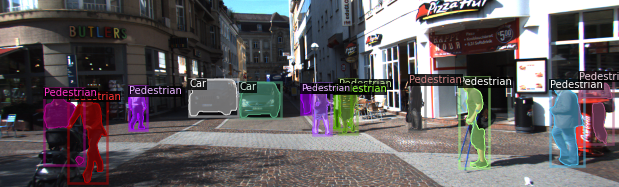

In [13]:
dataset_dicts = register_from_dataset(dataset_path, training)
for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=KITTI_MOTS_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    cv2_imshow(vis.get_image()[:, :, ::-1])

In [0]:
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg

# model_name = "COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"
model_name = "Cityscapes/mask_rcnn_R_50_FPN.yaml"
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file(model_name))
cfg.DATASETS.TRAIN = ("KITTI_MOTS_training",)
cfg.DATASETS.TEST = ()

cfg.DATASETS.PRECOMPUTED_PROPOSAL_TOPK_TRAIN = 3000 # default is 2000

cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(model_name)  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.LR_SCHEDULER_NAME = 'WarmupMultiStepLR'   # 'WarmupMultiStepLR' (default) or 'WarmupCosineLR'
cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
cfg.SOLVER.MAX_ITER = 5000    # 300 iterations seems good enough for this toy dataset; you may need to train longer for a practical dataset
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 2  # only has one class (ballon)

cfg.OUTPUT_DIR = output_path


In [11]:
cfg.OUTPUT_DIR

'./output1/'

In [12]:
cfg.DATASETS.PRECOMPUTED_PROPOSAL_TOPK_TRAIN

3000

In [17]:
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)

[04/11 23:25:58 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

In [18]:
trainer.train()

[04/11 19:56:04 d2.engine.train_loop]: Starting training from iteration 0
[04/11 19:56:14 d2.utils.events]:  eta: 0:39:47  iter: 19  total_loss: 2.732  loss_cls: 1.111  loss_box_reg: 0.872  loss_mask: 0.692  loss_rpn_cls: 0.024  loss_rpn_loc: 0.023  time: 0.4890  data_time: 0.2626  lr: 0.000005  max_mem: 3253M
[04/11 19:56:23 d2.utils.events]:  eta: 0:37:53  iter: 39  total_loss: 2.748  loss_cls: 1.090  loss_box_reg: 0.930  loss_mask: 0.689  loss_rpn_cls: 0.034  loss_rpn_loc: 0.024  time: 0.4705  data_time: 0.1906  lr: 0.000010  max_mem: 3253M
[04/11 19:56:33 d2.utils.events]:  eta: 0:37:09  iter: 59  total_loss: 2.653  loss_cls: 1.040  loss_box_reg: 0.894  loss_mask: 0.683  loss_rpn_cls: 0.009  loss_rpn_loc: 0.014  time: 0.4698  data_time: 0.2242  lr: 0.000015  max_mem: 3253M
[04/11 19:56:43 d2.utils.events]:  eta: 0:36:57  iter: 79  total_loss: 2.649  loss_cls: 0.972  loss_box_reg: 0.898  loss_mask: 0.675  loss_rpn_cls: 0.045  loss_rpn_loc: 0.029  time: 0.4743  data_time: 0.2292  lr:

zzz

In [5]:
# Look at training curves in tensorboard:
output_path_split = output_path.split('/')[-2]
print (output_path_split)
%load_ext tensorboard
# %tensorboard --logdir output
%tensorboard --logdir {output_path_split}

Output hidden; open in https://colab.research.google.com to view.

In [0]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set the testing threshold for this model
cfg.DATASETS.TEST = ("KITTI_MOTS_val", )
predictor = DefaultPredictor(cfg)

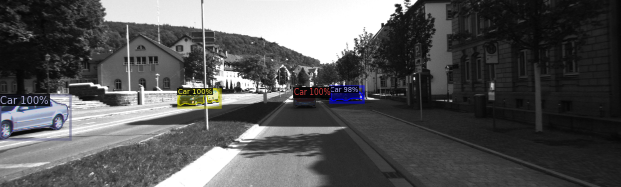

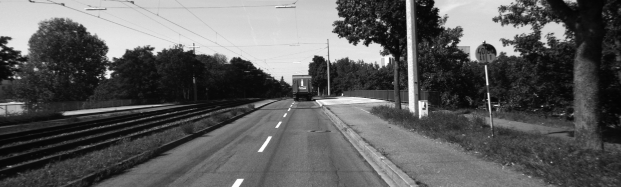

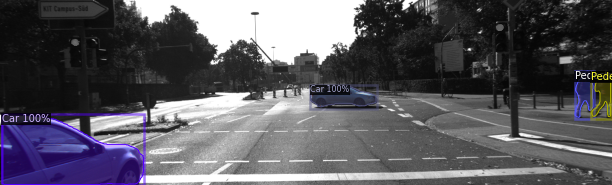

In [14]:
from detectron2.utils.visualizer import ColorMode
import pickle
dataset_dicts = register_from_dataset(dataset_path, validation)

exmaple_list = random.sample(dataset_dicts, 3)
with open("exmaple_list.pkl", 'wb') as f:
    pickle.dump(exmaple_list, f)
    f.close()
# with open("exmaple_list.pkl", 'rb') as p:
#     exmaple_list = pickle.load(p)
#     p.close()

for d in exmaple_list:    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=KITTI_MOTS_metadata, 
                   scale=0.5, 
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels
    )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(v.get_image()[:, :, ::-1])

generate the corresponding ground truth

[{'file_name': '../../KITTI-MOTS/training/image_02/0011/000091.png', 'image_id': 2615, 'height': 375, 'width': 1242, 'annotations': [{'bbox': [587.0, 176.0, 633.0, 218.0], 'bbox_mode': <BoxMode.XYXY_ABS: 0>, 'segmentation': [[601, 176, 600, 177, 598, 177, 597, 178, 596, 178, 594, 180, 594, 181, 592, 183, 592, 184, 589, 187, 588, 187, 587, 188, 587, 189, 589, 191, 589, 199, 588, 200, 588, 216, 589, 217, 594, 217, 594, 216, 596, 214, 600, 214, 601, 213, 603, 213, 604, 214, 624, 214, 626, 216, 627, 216, 628, 217, 629, 217, 630, 216, 631, 216, 631, 215, 632, 214, 632, 197, 631, 196, 631, 191, 632, 190, 632, 188, 629, 185, 629, 184, 627, 182, 627, 181, 626, 180, 626, 179, 625, 179, 623, 177, 620, 177, 619, 176]], 'category_id': 0, 'iscrowd': 0}, {'bbox': [0.0, 192.0, 139.0, 280.0], 'bbox_mode': <BoxMode.XYXY_ABS: 0>, 'segmentation': [[21, 192, 20, 193, 13, 193, 12, 194, 6, 194, 5, 195, 0, 195, 0, 275, 1, 276, 2, 276, 3, 277, 4, 277, 5, 278, 6, 278, 7, 279, 10, 279, 11, 278, 14, 278, 15, 277

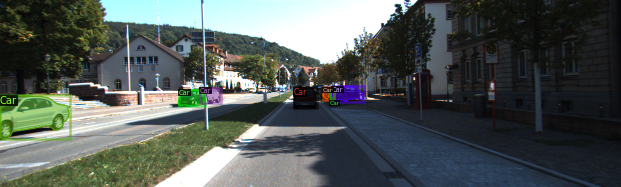

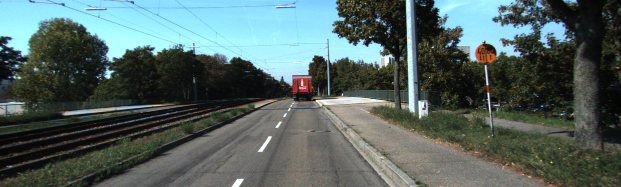

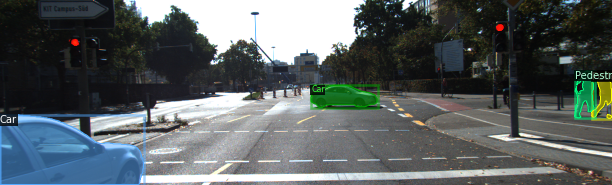

In [15]:
print (exmaple_list)
for d in exmaple_list:
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=KITTI_MOTS_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    cv2_imshow(vis.get_image()[:, :, ::-1])

In [18]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
evaluator = COCOEvaluator("KITTI_MOTS_val", cfg, False, output_dir=output_path)
val_loader = build_detection_test_loader(cfg, "KITTI_MOTS_val")
inference_on_dataset(trainer.model, val_loader, evaluator)
# another equivalent way is to use trainer.test

[04/11 23:27:03 d2.data.common]: Serializing 3273 elements to byte tensors and concatenating them all ...
[04/11 23:27:03 d2.data.common]: Serialized dataset takes 8.03 MiB
[04/11 23:27:03 d2.evaluation.evaluator]: Start inference on 3273 images
[04/11 23:27:09 d2.evaluation.evaluator]: Inference done 11/3273. 0.1721 s / img. ETA=0:21:00
[04/11 23:27:15 d2.evaluation.evaluator]: Inference done 24/3273. 0.1733 s / img. ETA=0:24:05
[04/11 23:27:21 d2.evaluation.evaluator]: Inference done 36/3273. 0.1728 s / img. ETA=0:24:25
[04/11 23:27:26 d2.evaluation.evaluator]: Inference done 51/3273. 0.1730 s / img. ETA=0:22:22
[04/11 23:27:31 d2.evaluation.evaluator]: Inference done 63/3273. 0.1731 s / img. ETA=0:22:18
[04/11 23:27:37 d2.evaluation.evaluator]: Inference done 79/3273. 0.1726 s / img. ETA=0:22:01
[04/11 23:27:42 d2.evaluation.evaluator]: Inference done 93/3273. 0.1722 s / img. ETA=0:21:32
[04/11 23:27:47 d2.evaluation.evaluator]: Inference done 110/3273. 0.1723 s / img. ETA=0:20:34
[

OrderedDict([('bbox',
              {'AP': 56.95104668903321,
               'AP-Car': 72.33926965559621,
               'AP-Pedestrian': 41.56282372247023,
               'AP50': 73.82516694095047,
               'AP75': 65.33530214691669,
               'APl': 67.14774362499037,
               'APm': 74.57309367415677,
               'APs': 38.21482731291742}),
             ('segm',
              {'AP': 50.18294335402758,
               'AP-Car': 71.43167362486743,
               'AP-Pedestrian': 28.934213083187725,
               'AP50': 71.55358291246031,
               'AP75': 54.944508075223986,
               'APl': 77.9545863501058,
               'APm': 64.25777609598443,
               'APs': 31.814411108561398})])

In [22]:
from tqdm import tqdm

dataset_location = dataset_path
detections_all_camera = {}
for sequence in test_seq:
    print (str(sequence).zfill(4))
    sequence_location = "{}/{}/".format(dataset_location, str(sequence).zfill(4))
    detections = []
    for frame in tqdm(sorted(os.listdir(sequence_location))):
        frame_filename = "{}{}".format(sequence_location, frame)
        im = cv2.imread(frame_filename)
        outputs = predictor(im)

        # print(outputs)
        classes = outputs["instances"].pred_classes.to("cpu").numpy()
        boxes = outputs["instances"].pred_boxes.to("cpu").tensor.numpy()
        scores = outputs["instances"].scores.to("cpu").numpy()
        
        # print (classes)
        for k, label in enumerate(classes):
            # print(k, label)
            frame_id = int(frame.split('.')[0])
            bbox = boxes[k]
            score = scores[k]
            
            detection = {}
            box_w = bbox[2] - bbox[0]
            box_h = bbox[3] - bbox[1]
            detection['frame'] = frame_id
            detection['left'] = bbox[0]
            detection['top'] = bbox[1]
            detection['width'] = box_w
            detection['height'] = box_h
            detection['confidence'] = score
            detection['label'] = label
            detections.append(detection)
    detections_all_camera[sequence] = detections


  0%|          | 0/314 [00:00<?, ?it/s]

0004


  0%|          | 0/297 [00:00<?, ?it/s]

0005


  0%|          | 0/800 [00:00<?, ?it/s]

0007


  0%|          | 0/390 [00:00<?, ?it/s]

0008


  0%|          | 0/803 [00:00<?, ?it/s]

0009


  0%|          | 0/373 [00:00<?, ?it/s]

0011


  0%|          | 0/376 [00:00<?, ?it/s]

0015


100%|██████████| 376/376 [01:25<00:00,  4.42it/s]


In [0]:
import pickle
with open("detections_all_test_seq.pkl", 'wb') as f:
    pickle.dump(detections_all_camera, f)
    f.close()